# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 20.09.2022

Мягкий дедлайн: 23:59MSK 04.10.2022

Жесткий дедлайн: 23:59MSK 10.10.2022

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит предсказывать год выпуска песни (**задача регрессии**) по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [157]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import random
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [ ]:
# %conda install wget

In [166]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2022-10-10 16:27:15--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 211011981 (201M) [application/x-httpd-php]
Saving to: ‘data.txt.zip’

data.txt.zip        100%[===================>] 201.24M  37.4MB/s    in 5.8s    

2022-10-10 16:27:21 (34.9 MB/s) - ‘data.txt.zip’ saved [211011981/211011981]



In [167]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


In [585]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

In [65]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [66]:
ridge = Ridge(10).fit(X_train, y_train)
print(f"Test: {mean_squared_error(y_test, ridge.predict(X_test), squared=False)}")

Test: 9.510160746337895


Лучшее качество (RMSE) для Ridge: 9.51.

In [67]:
train_min_rmse = -1
const_year = -1

for year in range(df.iloc[:, 0].min(), df.iloc[:, 0].max() + 1):
  rmse = mean_squared_error(y_train, np.full(y_train.shape, year), 
                            squared=False)

  if train_min_rmse == -1 or rmse < train_min_rmse:
    train_min_rmse = rmse
    const_year = year

min_rmse = mean_squared_error(y_test, np.full(y_test.shape, const_year), 
                              squared=False)

print(min_rmse)
print(const_year)

10.863228020678134
1998


Лучшее качество для константной модели: 10.86, год - 1998.

## Задание 1. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Не забудьте, что для улучшения качества модели вам поможет **нормировка таргета**.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из ячейки ниже.



In [68]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться следующими сигнатурами функций. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

In [526]:
set_random_seed(177)

In [527]:
class SongsDataset(torch.utils.data.Dataset):
  def __init__(self, X, y):
    self.X = X # признаки
    self.y = y # правильные ответы
  
  def __len__(self):
    return len(self.y)
  
  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

In [528]:
from sklearn import preprocessing

In [586]:
# https://intel.github.io/scikit-learn-intelex/samples/linear_regression.html
# пример нормализации взял отсюда
x_scaler = preprocessing.MinMaxScaler().fit(X_train)
y_scaler = preprocessing.StandardScaler().fit(y_train.reshape(-1, 1))

X_train = x_scaler.transform(X_train)
X_test = x_scaler.transform(X_test)

y_train = y_scaler.transform(y_train.reshape(-1, 1)).ravel()
y_test = y_scaler.transform(y_test.reshape(-1, 1)).ravel()

In [587]:
set_random_seed(177)
train_set = SongsDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)

test_set = SongsDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True)

model = nn.Sequential(
    nn.Linear(90, 45),
    nn.BatchNorm1d(45),
    nn.ReLU(),
    nn.Linear(45, 15),
    nn.BatchNorm1d(15),
    nn.ReLU(),
    nn.Linear(15, 5),
    nn.BatchNorm1d(5),
    nn.ReLU(),
    nn.Linear(5, 1)
)

cnt_epochs = 10
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = F.mse_loss
scheduler = None

In [531]:
torch.cuda.is_available()

if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

In [588]:
loss_values = []

In [567]:
import warnings
warnings.filterwarnings('ignore')

In [613]:
def train(model, optimizer, criterion, scheduler, cnt_epochs, train_loader, test_loader):
    '''
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
        test_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
    '''
    
    for epoch in range(cnt_epochs):
      for x_train, y_train in tqdm(train_loader):
        y_pred = model(x_train.float()).to(device).ravel()
        loss = F.mse_loss(y_pred, y_train.float())
        a = y_pred.detach().numpy()
        b = a.reshape(-1, 1)
        c = torch.tensor(y_scaler.inverse_transform(b))
        loss_values.append(get_loss(criterion, c, y_train, y_scaler))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

      if scheduler is not None:
        scheduler.step()


def test(model, criterion, test_loader):
    '''
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        test_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    '''
    with torch.no_grad():
      predictions = model(torch.from_numpy(X_test).float())

      return torch.from_numpy(y_scaler.inverse_transform(predictions))


def get_loss(criterion, predictions, y_test, y_scaler):
  answers = torch.from_numpy(y_scaler.inverse_transform(y_test.reshape(-1, 1)))
  
  return torch.sqrt(criterion(predictions, answers)).tolist()

In [614]:
train(model, optimizer, criterion, scheduler, cnt_epochs, train_loader, test_loader)

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/14492 [00:00<?, ?it/s]

In [615]:
pred = test(model, criterion, test_loader)
pred

tensor([[1999.6498],
        [2003.9419],
        [2001.8908],
        ...,
        [1999.1221],
        [2001.6094],
        [2001.0342]], dtype=torch.float64)

In [616]:
get_loss(criterion, pred, y_test, y_scaler)

8.775110881783505

In [617]:
import seaborn as sns
import matplotlib.pyplot as plt

In [618]:
df_loss = pd.DataFrame(loss_values)
df_loss.head()

,0
0,12.247498
1,18.925688
2,9.680715
3,9.970665
4,11.525704


Графики, показывающие RMSE на тренировочной выборке в зависимости от номера шага (разные графики - разные масштабы)

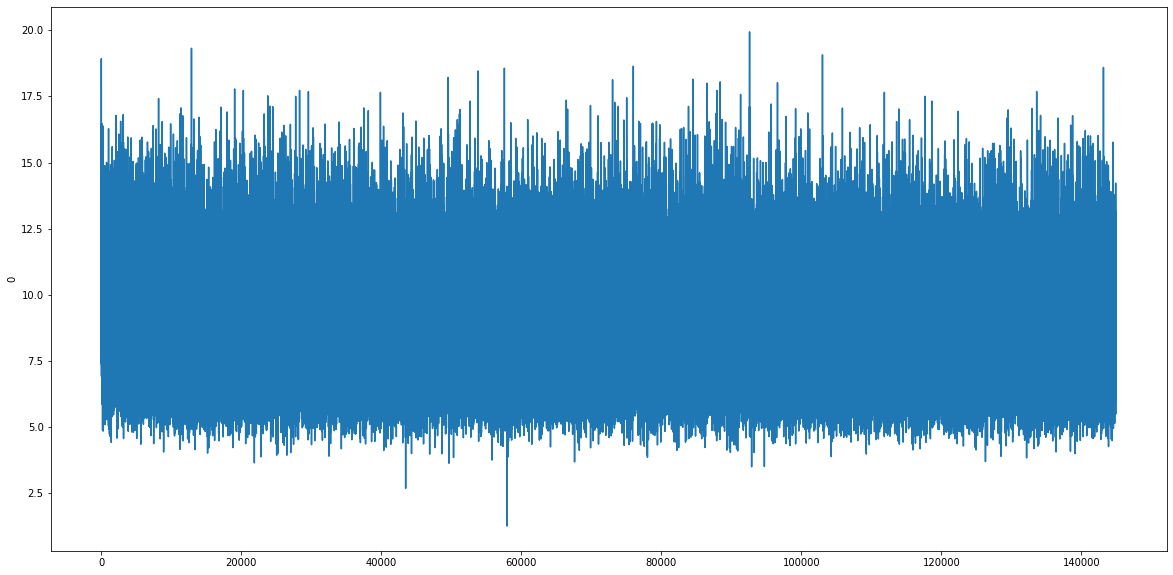

In [619]:
plt.figure(figsize=(20, 10))
sns.lineplot(data=df_loss, x=df_loss.index, y=0)

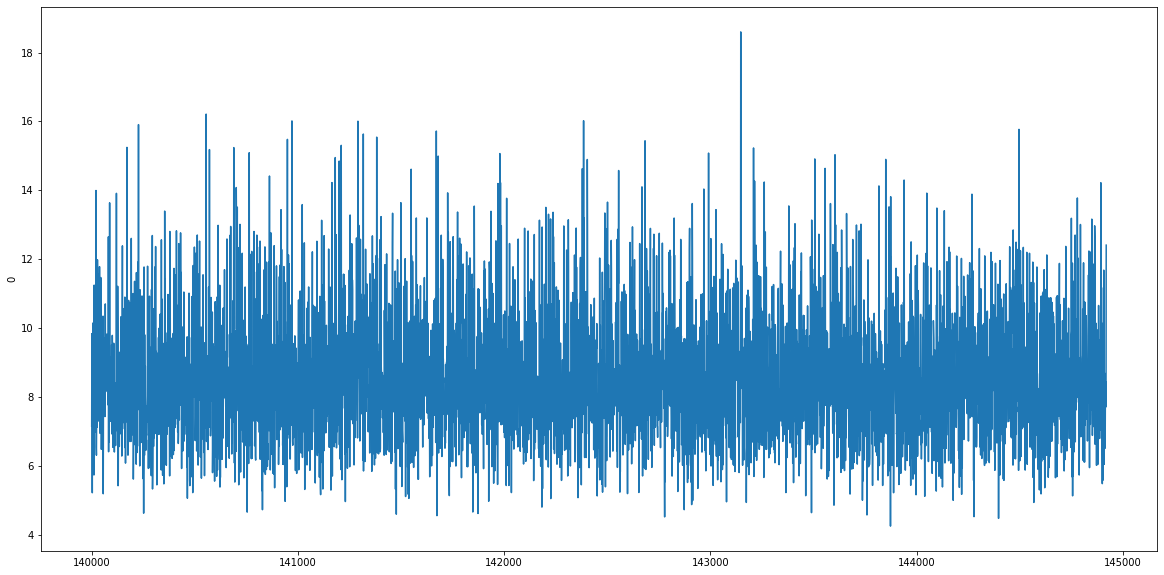

In [621]:
plt.figure(figsize=(20, 10))
sns.lineplot(data=df_loss[140000:], x=df_loss[140000:].index, y=0)

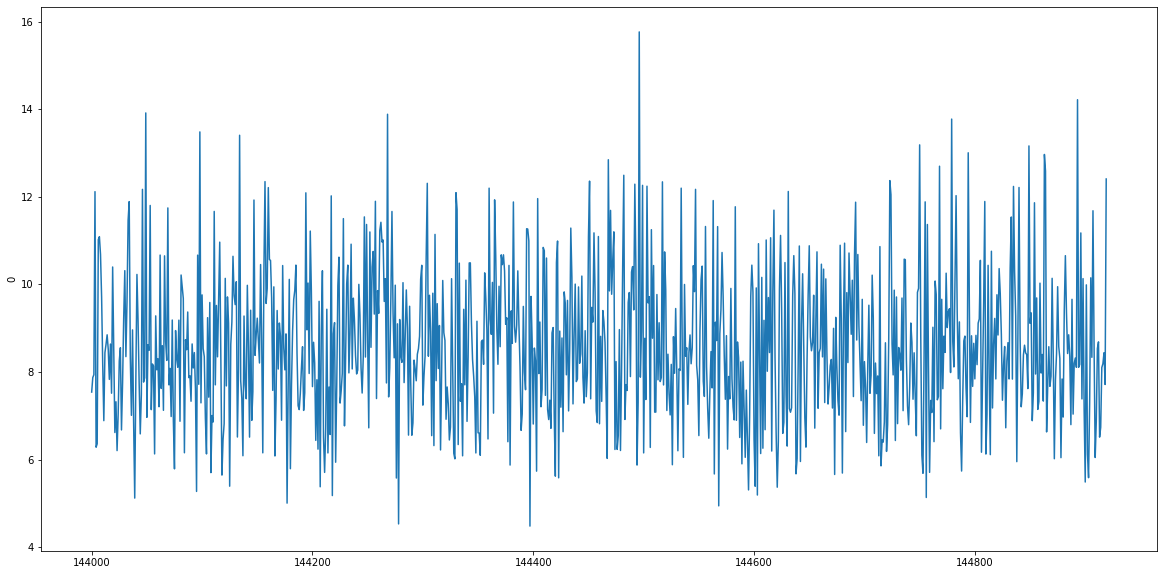

In [622]:
plt.figure(figsize=(20, 10))
sns.lineplot(data=df_loss[144000:], x=df_loss[144000:].index, y=0)

In [ ]:
assert test(model, criterion, test_loader).shape[0] == y_test.shape[0]

In [584]:
pr = model(torch.from_numpy(X_train).float())
torch.from_numpy(y_scaler.inverse_transform(pr.detach().numpy()))

tensor([[1999.2057],
        [1994.8654],
        [1996.2948],
        ...,
        [1989.0687],
        [2003.4745],
        [1996.4131]])

## Задание 2. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

**Первый эксперимент**

Простейшая двухслойная полносвязная модель, стохастический градиентный спуск с шагом 0.01, 10 эпох, размер батча - 32

In [234]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

In [235]:
x_scaler = preprocessing.MinMaxScaler().fit(X_train)
y_scaler = preprocessing.StandardScaler().fit(y_train.reshape(-1, 1))

X_train = x_scaler.transform(X_train)
X_test = x_scaler.transform(X_test)

y_train = y_scaler.transform(y_train.reshape(-1, 1)).ravel()
y_test = y_scaler.transform(y_test.reshape(-1, 1)).ravel()

In [236]:
set_random_seed(177)
train_set = SongsDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)

test_set = SongsDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True)

In [237]:
model1 = nn.Sequential(
    nn.Linear(90, 30),
    nn.ReLU(),
    nn.Linear(30, 1)
)

cnt_epochs1 = 10
optimizer1 = torch.optim.SGD(model1.parameters(), lr=0.01)
criterion1 = F.mse_loss
scheduler1 = None

In [238]:
train(model1, optimizer1, criterion1, scheduler1, cnt_epochs1, train_loader, test_loader)

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/14492 [00:00<?, ?it/s]

In [239]:
pred1 = test(model1, criterion1, test_loader)
pred1

tensor([[1998.7077],
        [2008.8697],
        [2005.1600],
        ...,
        [2004.8690],
        [2006.2542],
        [2005.6816]], dtype=torch.float64)

In [240]:
get_loss(criterion1, pred1, y_test, y_scaler)

10.240062960865954

RMSE: 10.24

**Второй эксперимент**

То же самое, но 5 эпох вместо 10

In [241]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

In [242]:
x_scaler = preprocessing.MinMaxScaler().fit(X_train)
y_scaler = preprocessing.StandardScaler().fit(y_train.reshape(-1, 1))

X_train = x_scaler.transform(X_train)
X_test = x_scaler.transform(X_test)

y_train = y_scaler.transform(y_train.reshape(-1, 1)).ravel()
y_test = y_scaler.transform(y_test.reshape(-1, 1)).ravel()

In [243]:
set_random_seed(177)
train_set = SongsDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)

test_set = SongsDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True)

In [244]:
model2 = nn.Sequential(
    nn.Linear(90, 30),
    nn.ReLU(),
    nn.Linear(30, 1)
)

cnt_epochs2 = 5
optimizer2 = torch.optim.SGD(model2.parameters(), lr=0.01)
criterion2 = F.mse_loss
scheduler2 = None

In [245]:
train(model2, optimizer2, criterion2, scheduler2, cnt_epochs2, train_loader, test_loader)

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/14492 [00:00<?, ?it/s]

In [246]:
pred2 = test(model2, criterion2, test_loader)
pred2

tensor([[1993.5294],
        [2001.7414],
        [1998.2961],
        ...,
        [1998.9067],
        [2003.0990],
        [1999.0803]], dtype=torch.float64)

In [247]:
get_loss(criterion2, pred2, y_test, y_scaler)

9.419744961273345

RMSEL 9.42. Значительно лучше, чем при 10 эпохах, так что далее всегда будет использоваться 5 эпох.

**Третий эксперимент**

Добавим несколько слоёв в модель

In [248]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

In [249]:
x_scaler = preprocessing.MinMaxScaler().fit(X_train)
y_scaler = preprocessing.StandardScaler().fit(y_train.reshape(-1, 1))

X_train = x_scaler.transform(X_train)
X_test = x_scaler.transform(X_test)

y_train = y_scaler.transform(y_train.reshape(-1, 1)).ravel()
y_test = y_scaler.transform(y_test.reshape(-1, 1)).ravel()

In [250]:
set_random_seed(177)
train_set = SongsDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)

test_set = SongsDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True)

In [251]:
model3 = nn.Sequential(
    nn.Linear(90, 45),
    nn.ReLU(),
    nn.Linear(45, 15),
    nn.ReLU(),
    nn.Linear(15, 5),
    nn.ReLU(),
    nn.Linear(5, 1),
)

cnt_epochs3 = 5
optimizer3 = torch.optim.SGD(model3.parameters(), lr=0.01)
criterion3 = F.mse_loss
scheduler3 = None

In [252]:
train(model3, optimizer3, criterion3, scheduler3, cnt_epochs3, train_loader, test_loader)

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/14492 [00:00<?, ?it/s]

In [253]:
pred3 = test(model3, criterion3, test_loader)
pred3

tensor([[1998.3896],
        [2004.9867],
        [2002.9988],
        ...,
        [2003.6934],
        [2004.1715],
        [2004.1311]], dtype=torch.float64)

In [255]:
get_loss(criterion3, pred3, y_test, y_scaler)

9.87581352684524

RMSE: 9.88. Метрика ухудшилась.

**Четвёртый эксперимент**

Используем Adam вместо SGD

In [256]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

In [257]:
x_scaler = preprocessing.MinMaxScaler().fit(X_train)
y_scaler = preprocessing.StandardScaler().fit(y_train.reshape(-1, 1))

X_train = x_scaler.transform(X_train)
X_test = x_scaler.transform(X_test)

y_train = y_scaler.transform(y_train.reshape(-1, 1)).ravel()
y_test = y_scaler.transform(y_test.reshape(-1, 1)).ravel()

In [258]:
set_random_seed(177)
train_set = SongsDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)

test_set = SongsDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True)

In [259]:
model4 = nn.Sequential(
    nn.Linear(90, 45),
    nn.ReLU(),
    nn.Linear(45, 15),
    nn.ReLU(),
    nn.Linear(15, 5),
    nn.ReLU(),
    nn.Linear(5, 1),
)

cnt_epochs4 = 5
optimizer4 = torch.optim.Adam(model4.parameters(), lr=0.01)
criterion4 = F.mse_loss
scheduler4 = None

In [260]:
train(model4, optimizer4, criterion4, scheduler4, cnt_epochs4, train_loader, test_loader)

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/14492 [00:00<?, ?it/s]

In [261]:
pred4 = test(model4, criterion4, test_loader)
pred4

tensor([[1998.1595],
        [1998.1595],
        [1998.1595],
        ...,
        [1998.1595],
        [1998.1595],
        [1998.1595]], dtype=torch.float64)

In [262]:
get_loss(criterion4, pred4, y_test, y_scaler)

10.857116923046663

RMSE: 10.85. Модель не только ухудшилась, но и стала константной.

**Пятый эксперимент**

Добавим батч-нормализацию и вернём SGD

In [385]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

In [386]:
x_scaler = preprocessing.MinMaxScaler().fit(X_train)
y_scaler = preprocessing.StandardScaler().fit(y_train.reshape(-1, 1))

X_train = x_scaler.transform(X_train)
X_test = x_scaler.transform(X_test)

y_train = y_scaler.transform(y_train.reshape(-1, 1)).ravel()
y_test = y_scaler.transform(y_test.reshape(-1, 1)).ravel()

In [387]:
set_random_seed(177)
train_set = SongsDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)

test_set = SongsDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True)

In [388]:
model5 = nn.Sequential(
    nn.Linear(90, 45),
    nn.BatchNorm1d(45),
    nn.ReLU(),
    nn.Linear(45, 15),
    nn.BatchNorm1d(15),
    nn.ReLU(),
    nn.Linear(15, 5),
    nn.BatchNorm1d(5),
    nn.ReLU(),
    nn.Linear(5, 1),
)

cnt_epochs5 = 5
optimizer5 = torch.optim.SGD(model5.parameters(), lr=0.01)
criterion5 = F.mse_loss
scheduler5 = None

In [389]:
train(model5, optimizer5, criterion5, scheduler5, cnt_epochs5, train_loader, test_loader)

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/14492 [00:00<?, ?it/s]

In [390]:
pred5 = test(model5, criterion5, test_loader)
pred5

tensor([[1999.5166],
        [2003.2892],
        [2001.4715],
        ...,
        [2000.3260],
        [2000.4475],
        [2002.0392]], dtype=torch.float64)

In [391]:
get_loss(criterion5, pred5, y_test, y_scaler)

8.861557300217049

RMSE: 8.86. Качество значительно улучшилось

**Шестой эксперимент**

Снова заменим SGD на Adam

In [271]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

In [272]:
x_scaler = preprocessing.MinMaxScaler().fit(X_train)
y_scaler = preprocessing.StandardScaler().fit(y_train.reshape(-1, 1))

X_train = x_scaler.transform(X_train)
X_test = x_scaler.transform(X_test)

y_train = y_scaler.transform(y_train.reshape(-1, 1)).ravel()
y_test = y_scaler.transform(y_test.reshape(-1, 1)).ravel()

In [273]:
set_random_seed(177)
train_set = SongsDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)

test_set = SongsDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True)

In [274]:
model6 = nn.Sequential(
    nn.Linear(90, 45),
    nn.BatchNorm1d(45),
    nn.ReLU(),
    nn.Linear(45, 15),
    nn.BatchNorm1d(15),
    nn.ReLU(),
    nn.Linear(15, 5),
    nn.BatchNorm1d(5),
    nn.ReLU(),
    nn.Linear(5, 1),
)

cnt_epochs6 = 5
optimizer6 = torch.optim.Adam(model6.parameters(), lr=0.01)
criterion6 = F.mse_loss
scheduler6 = None

In [275]:
train(model6, optimizer6, criterion6, scheduler6, cnt_epochs6, train_loader, test_loader)

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/14492 [00:00<?, ?it/s]

In [276]:
pred6 = test(model6, criterion6, test_loader)
pred6

tensor([[2000.4758],
        [2003.6126],
        [2001.3567],
        ...,
        [2000.3776],
        [2000.6022],
        [2001.9097]], dtype=torch.float64)

In [277]:
get_loss(criterion6, pred6, y_test, y_scaler)

8.812697653477427

RMSE: 8.81. Качество стало ещё лучше

**Седьмой эксперимент**

Увеличим количество эпох с 5 до 10

In [518]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

In [519]:
x_scaler = preprocessing.MinMaxScaler().fit(X_train)
y_scaler = preprocessing.StandardScaler().fit(y_train.reshape(-1, 1))

X_train = x_scaler.transform(X_train)
X_test = x_scaler.transform(X_test)

y_train = y_scaler.transform(y_train.reshape(-1, 1)).ravel()
y_test = y_scaler.transform(y_test.reshape(-1, 1)).ravel()

In [520]:
set_random_seed(177)
train_set = SongsDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)

test_set = SongsDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True)

In [521]:
model7 = nn.Sequential(
    nn.Linear(90, 45),
    nn.BatchNorm1d(45),
    nn.ReLU(),
    nn.Linear(45, 15),
    nn.BatchNorm1d(15),
    nn.ReLU(),
    nn.Linear(15, 5),
    nn.BatchNorm1d(5),
    nn.ReLU(),
    nn.Linear(5, 1)
)

cnt_epochs7 = 10
optimizer7 = torch.optim.Adam(model7.parameters(), lr=0.005)
criterion7 = F.mse_loss
scheduler7 = None

In [522]:
train(model7, optimizer7, criterion7, scheduler7, cnt_epochs7, train_loader, test_loader)

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/14492 [00:00<?, ?it/s]

In [523]:
pred7 = test(model7, criterion7, test_loader)
pred7

tensor([[2000.2951],
        [2003.3888],
        [2002.5985],
        ...,
        [2000.9190],
        [2002.7458],
        [2001.2365]], dtype=torch.float64)

In [524]:
get_loss(criterion7, pred7, y_test, y_scaler)

8.771802044398214

RMSE: 8.77. Пока что лучшая модель

**Восьмой эксперимент**

In [511]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

In [512]:
x_scaler = preprocessing.MinMaxScaler().fit(X_train)
y_scaler = preprocessing.StandardScaler().fit(y_train.reshape(-1, 1))

X_train = x_scaler.transform(X_train)
X_test = x_scaler.transform(X_test)

y_train = y_scaler.transform(y_train.reshape(-1, 1)).ravel()
y_test = y_scaler.transform(y_test.reshape(-1, 1)).ravel()

In [513]:
set_random_seed(177)
train_set = SongsDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)

test_set = SongsDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True)

In [514]:
model0 = nn.Sequential(
    nn.Linear(90, 45),
    nn.BatchNorm1d(45),
    nn.ReLU(),
    nn.Linear(45, 15),
    nn.BatchNorm1d(15),
    nn.ReLU(),
    nn.Linear(15, 5),
    nn.BatchNorm1d(5),
    nn.ReLU(),
    nn.Linear(5, 1),
)

cnt_epochs0 = 10
optimizer0 = torch.optim.Adam(model0.parameters(), lr=0.005)
criterion0 = F.mse_loss
#scheduler0 = None
scheduler_func = lambda epoch: 0.65 ** epoch
scheduler0 = torch.optim.lr_scheduler.LambdaLR(optimizer0, scheduler_func)

In [515]:
train(model0, optimizer0, criterion0, scheduler0, cnt_epochs0, train_loader, test_loader)

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/14492 [00:00<?, ?it/s]

In [516]:
pred0 = test(model0, criterion0, test_loader)
pred0

tensor([[1998.8440],
        [2003.3693],
        [2001.0683],
        ...,
        [1998.7233],
        [2000.4162],
        [2001.7948]], dtype=torch.float64)

In [517]:
get_loss(criterion0, pred0, y_test, y_scaler)

8.778177502812673

RMSE: 8.778. Хуже, чем в седьмом эксперименте

Итог: лучшим оказался седьмой эксперимент. Dropout, weight_decay и scheduler не помогли улучшить метрику.